In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv(r'C:\Users\marek\OneDrive\Pulpit\Inzynierka\bank-additional-full.csv', sep=';')
columns_to_drop = ['duration','euribor3m','emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed']
for column in columns_to_drop:
    df.drop(column, axis=1, inplace=True)
columns_to_replace_unknown = df.columns.difference(['default','housing','loan'])
df[columns_to_replace_unknown] = df[columns_to_replace_unknown].copy().replace('unknown', np.nan)

In [3]:
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: count, dtype: int64

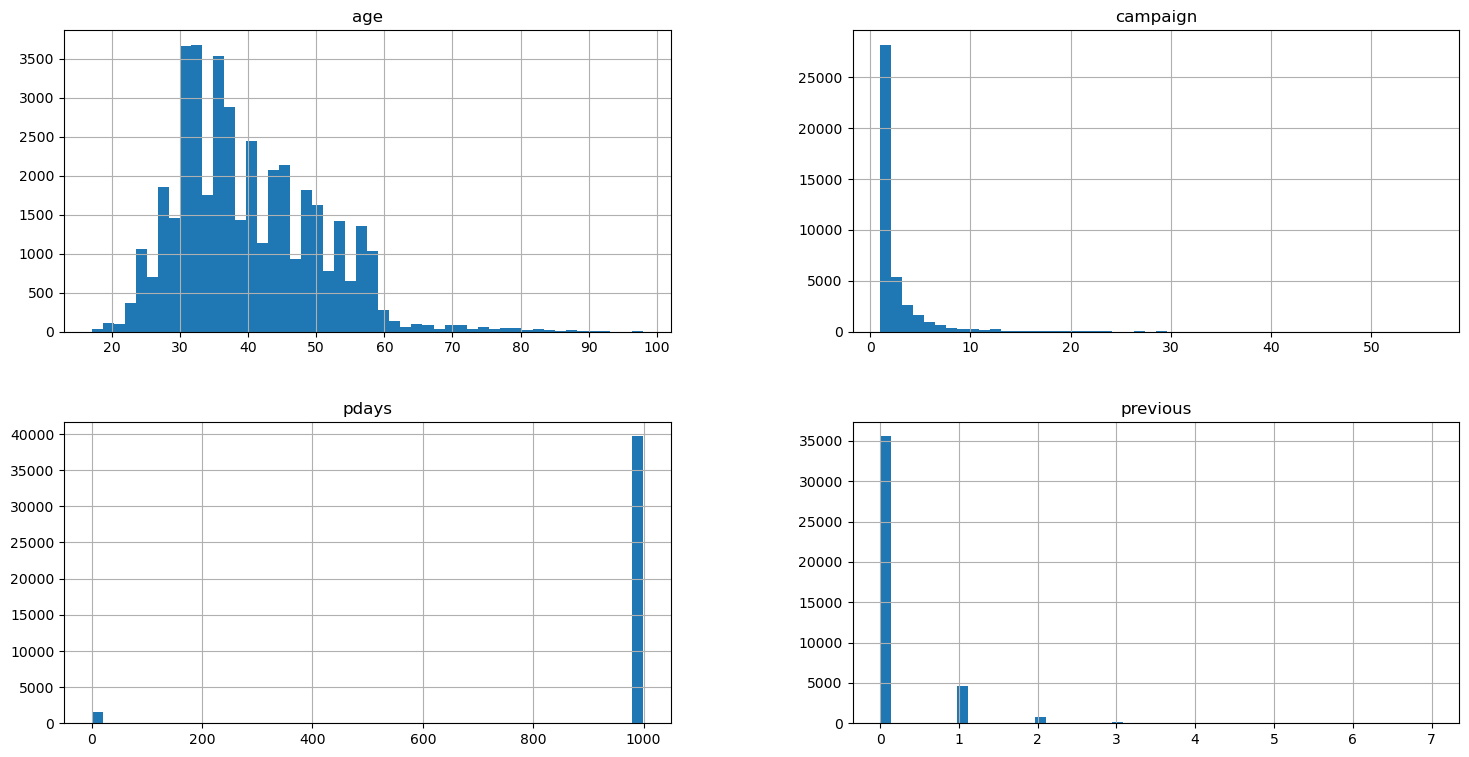

In [4]:
df.hist(bins=50, figsize=(18,9))
plt.show()

In [5]:
df.head(20)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
7,41,blue-collar,married,NaN,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no


In [6]:
def scaleMinMax(dataFrame, columnName):
    scaler = MinMaxScaler()
    series = dataFrame[columnName]
    scaled_data = scaler.fit_transform(series.values.reshape(-1,1))
    scaled_series = pd.Series(scaled_data.flatten(), index=series.index)
    dataFrame[columnName] = scaled_series

In [7]:
#najpierw skalujemy kolumnę wiek w wartości od 0 do 1, kolumna age nie posiada danych brakujących
scaleMinMax(df, 'age')

In [8]:
#teraz zajmiemy się kolumnami Job i Marital, dla obu zastosujemy dummmy typing, usuwając najpierw rekordy z NaN (wcześniej unknown)
categorical_for_dummies = ['job', 'marital']
[df.dropna(subset=x, inplace=True) for x in categorical_for_dummies]
#kolumny default, housing, loan i contact w wyniku dalszej analizy poddajemy również takiemu typowaniu
categorical_for_dummies.extend(['default', 'housing','loan','contact','poutcome'])
df = pd.get_dummies(df, columns=categorical_for_dummies)

In [9]:
#teraz zajmiemy się edukacją zamieniłem poziom nauki na wartośći 0-6 obrazujące ile ktoś się uczył (jaki uzyskał tytuł)
#dodatkowo wartości brakujące uzupełniłem średnią, na koniec zastosowałem skaler
df['education'].replace(['illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course',
                         'university.degree'], [0,1,2,3,4,5,6], inplace=True)
df['education'].fillna(df['education'].mean() ,inplace=True)

scaleMinMax(df, 'education')

In [10]:
#teraz zamienimy miesiące i dni tygodnia na wartośći 1-12 oraz 1-5, następnie poddamy je skalowaniu
df['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
                     [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True) 
df['day_of_week'].replace(['mon','tue','wed','thu','fri'], [1,2,3,4,5], inplace=True)

scaleMinMax(df, 'month')
scaleMinMax(df, 'day_of_week')

In [11]:
#Teraz zajmiemy się kolumną campaign, odrzucimy 0.5% największych ilości kontaktów. Powyżej 19 kontaktów liczba procent współczynnik sukcesu
#wyniosl w naszym zbiorze 1/186, w aplikacji jeśli ilość kontaktów byłaby większa, ustawimy ją na 19
quantile_995 = df['campaign'].quantile(0.995)
df = df[df['campaign'] <= quantile_995]
scaleMinMax(df, 'campaign')

In [12]:
#dostawiłem dodatkową kolumnę z brakiem kontaktu wcześniejszego oraz wykonałem log10, by ułatwił uczeniu maszynowemu predykcję
df['not_contacted_before'] = df['pdays'] == 999
df['pdays'] = df['pdays'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [13]:
#dla previous wykonałem tylko standardowy scaling MinMax
scaleMinMax(df, 'previous')

In [14]:
#df.where((df['pdays'] == 999) & (df['y'] == 1)).dropna()
#df.where((df['campaign'] > 19) & (df['y'] == 1)).dropna()

In [15]:
df['y'].replace(['no', 'yes'], [0, 1], inplace=True)
X = df.drop('y', axis=1)
Y = df['y']

In [16]:
X

,age,education,month,day_of_week,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,not_contacted_before
0,0.481481,0.166667,0.222222,0.0,0.000000,2.999565,0.000000,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,True
1,0.493827,0.666667,0.222222,0.0,0.000000,2.999565,0.000000,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False,True
2,0.246914,0.666667,0.222222,0.0,0.000000,2.999565,0.000000,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,False,True,False,True,False,True
3,0.283951,0.333333,0.222222,0.0,0.000000,2.999565,0.000000,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,True
4,0.481481,0.666667,0.222222,0.0,0.000000,2.999565,0.000000,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.691358,0.833333,0.888889,1.0,0.000000,2.999565,0.000000,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,True
41184,0.358025,0.833333,0.888889,1.0,0.000000,2.999565,0.000000,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True
41185,0.481481,1.000000,0.888889,1.0,0.055556,2.999565,0.000000,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,True
41186,0.333333,0.833333,0.888889,1.0,0.000000,2.999565,0.000000,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [18]:
from sklearn.tree import DecisionTreeClassifier
#Drzewa decyzyjne
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
# Wyświetlenie raportu klasyfikacji
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[3242  371]
 [ 290  158]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3613
           1       0.30      0.35      0.32       448

    accuracy                           0.84      4061
   macro avg       0.61      0.62      0.62      4061
weighted avg       0.85      0.84      0.84      4061



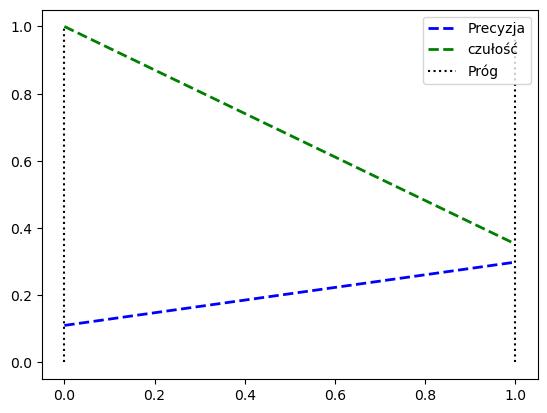

In [19]:
precissions, recalls, threshold = precision_recall_curve(y_test, y_pred)
plt.plot(threshold, precissions[:-1], "b--", label="Precyzja", linewidth=2)
plt.plot(threshold, recalls[:-1], "g--", label="czułość", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Próg")
plt.legend()
plt.show()

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[3504  109]
 [ 341  107]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3613
           1       0.50      0.24      0.32       448

    accuracy                           0.89      4061
   macro avg       0.70      0.60      0.63      4061
weighted avg       0.87      0.89      0.87      4061



In [21]:
from sklearn.svm import SVC

model = SVC(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[2584 1029]
 [ 163  285]]
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      3613
           1       0.22      0.64      0.32       448

    accuracy                           0.71      4061
   macro avg       0.58      0.68      0.57      4061
weighted avg       0.86      0.71      0.76      4061



In [22]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[3510  103]
 [ 354   94]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3613
           1       0.48      0.21      0.29       448

    accuracy                           0.89      4061
   macro avg       0.69      0.59      0.62      4061
weighted avg       0.86      0.89      0.87      4061



In [23]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[3563   50]
 [ 353   95]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3613
           1       0.66      0.21      0.32       448

    accuracy                           0.90      4061
   macro avg       0.78      0.60      0.63      4061
weighted avg       0.88      0.90      0.88      4061



In [24]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[3571   42]
 [ 360   88]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3613
           1       0.68      0.20      0.30       448

    accuracy                           0.90      4061
   macro avg       0.79      0.59      0.63      4061
weighted avg       0.88      0.90      0.88      4061



In [25]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[2558 1055]
 [ 178  270]]
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      3613
           1       0.20      0.60      0.30       448

    accuracy                           0.70      4061
   macro avg       0.57      0.66      0.56      4061
weighted avg       0.85      0.70      0.75      4061



In [26]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('svc', SVC(class_weight='balanced', random_state=42)),
        ('dtc',DecisionTreeClassifier(random_state=42)),
        ('gnb',GaussianNB())
    ]
)
voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Macierz pomyłek:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

Macierz pomyłek:
[[2785  828]
 [ 189  259]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      3613
           1       0.24      0.58      0.34       448

    accuracy                           0.75      4061
   macro avg       0.59      0.67      0.59      4061
weighted avg       0.86      0.75      0.79      4061

